## To do list:

* Figure out how to condense cell 2 into multiple for loops. The first for loop loops through all sites except Shale Hills sites, and Green and BGZOB sites. For Shale Hills sites, columns 2, 3, 6 and 7 should be nan. For Green and BGZOB sites, no columns should be nan. For all other sites, column 6 should be nan.

* Try to fill nans in a way that PCA doesn't change much

* Other ways to test the model and visualize results? Best ways to measure performance?

* Should PCA be run on all variables, or just X variables (no CO2)?

* Run model on original dataset
* There seems to be a tradeoff between maximum error and mean/median error. What is more important for predicting CO2 concentrations?
* Do we need PCA? After removing water potential and reduction potential, I'm not sure it makes sense to reduce the dimensionality of the data, and it doesn't seem to change the results of the model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive list
# of all potential features across all pits
features = ['CO2', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential']
m = len(features)

# Load in and merge all files
# NOTE: Only doing Calhoun R1C1 for now, but you get the idea
i = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        
        if pit not in ['R1C2', 'SFPit1', 'SPMS']:
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))

            # t is the number of time steps
            t = df.shape[0]

            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)

            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]

                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]

                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
            data[pit] = cur_data.copy()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive list
# of all potential features across all pits
features = ['CO2', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential']
m = len(features)

# Load in and merge all files
# NOTE: Only doing Calhoun R1C1 for now, but you get the idea
i = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        
        if pit == 'R1C1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
            data[pit] = cur_data.copy()
            
        if pit == 'R1H1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
       
    
        if pit == 'R1P1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'LRMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'TMMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'NPMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'SPVF':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
          
      
        if pit == 'BGZOB1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue
                        if np.all(df[col])==0:
                            df[col]=np.nan
                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'BGZOB2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
       
        if pit == 'BGZOB3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'BGZOB4':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'Green1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'Green2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'Green3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'MC3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC4':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'MC5':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC6':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()

In [2]:
merged=np.vstack(( data['R1C1'], data['R1H1'], data['R1P1'],  data['TMMS'], data['LRMS'], data['NPMS'], data['SPVF'], data['BGZOB1'], data['BGZOB2'], data['BGZOB3'], data['BGZOB4'], data['Green1'], data['Green2'], data['Green3'], data['MC1'], data['MC2'], data['MC3'], data['MC4'], data['MC5'], data['MC6']))
#
df=pd.DataFrame(data=merged, columns=['CO2', 'Precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential'])

In [3]:
df.dropna(subset=['CO2'], inplace=True)
df

,CO2,Precip,SoilMoisture,BulkEC,Temp,O2,WaterPotential,ReductionPotential
0,13180.00000,NaN,0.358,0.044,16.65000,19.409336,NaN,NaN
1,13570.00000,0.0,0.358,0.044,16.70500,19.413019,NaN,NaN
2,13830.00000,0.0,0.358,0.044,16.77000,19.417373,NaN,NaN
3,14100.00000,0.0,0.358,0.044,16.83500,19.421726,NaN,NaN
4,14315.00000,0.0,0.358,0.044,16.89000,19.425410,NaN,NaN
...,...,...,...,...,...,...,...,...
2691424,908.66450,NaN,NaN,NaN,1.95875,12.620250,NaN,412.000
2691425,899.26600,NaN,NaN,NaN,1.96000,12.633500,NaN,412.125
2691426,906.60550,NaN,NaN,NaN,1.95975,12.656000,NaN,412.100
2691427,907.19025,NaN,NaN,NaN,1.95500,12.660750,NaN,412.725


In [4]:
#df['WaterPotential'].isna().sum()


In [5]:
final_array=df.to_numpy()
output=final_array.copy()
outfile = '../../merged_processed_data/MergeProcessedData.csv'
#output.to_csv(outfile, na_rep=-99999, index_label='record', float_format='%.3f')
np.savetxt(outfile, output, fmt='%.4f', delimiter=",")


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [7]:
df=df.drop(columns='WaterPotential')
df=df.drop(columns='ReductionPotential')
df=df.dropna()

In [8]:
df_st =  StandardScaler().fit_transform(df) 
df_st1=pd.DataFrame(data=df_st)

#df_med=df_st1.fillna(df_st1.median())


In [9]:
#df.interpolate(axis=1, inplace=True)

In [10]:
from sklearn.model_selection import train_test_split

df_st1.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2']
X=df_st1[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2']]  # Features\n",
y=df_st1['CO2']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)


In [11]:
#df_st1=pd.DataFrame(data=df_st)
#df_med = df_st1.fillna(df_st1.median())
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [12]:
pca.explained_variance_ratio_


array([0.38262797, 0.21062833, 0.17399592, 0.13160247, 0.10114531])

In [13]:
pca_out=pca
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5
variable,,,,,
Precip,0.086734,0.766796,-0.628719,0.089698,-0.034183
Soil Moisture,0.561139,0.088416,0.077080,-0.515428,0.636944
Bulk EC,0.540199,0.045805,0.236637,0.795293,0.132663
Temp,-0.224845,0.634114,0.732044,-0.092685,-0.053529
O2,-0.578990,-0.002957,-0.082980,0.291903,0.756749


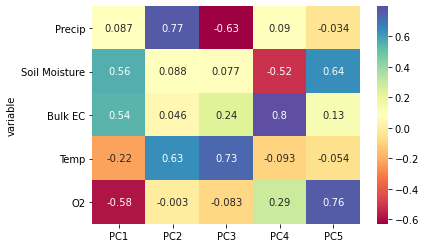

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

In [15]:
pca_scores = PCA().fit_transform(X_train)

In [16]:
import bioinfokit
from bioinfokit.visuz import cluster
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=X.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

In [17]:
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

In [18]:
#from sklearn.model_selection import train_test_split

#X=df_st1[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'WaterPotential','Reduction Potential']]  # Features\n",
#y=df_st1['CO2']  # Labels\n",

# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
#from sklearn.svm import LinearSVR
#from sklearn import svm
#regr = svm.LinearSVR(max_iter=5000)
#regr.fit(X_train, y_train)
#from sklearn import metrics
#regr.score(X_test, y_test)

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
neigh.score(X_test,y_test)

0.9833125167192198

In [20]:
len(X_train)


379151

In [21]:
#X_original=df.iloc[y_train]
prediction=neigh.predict(X_test)
df_pred=pd.DataFrame(data=prediction)
#prediction_original_dataset=neigh.predict(X_original)


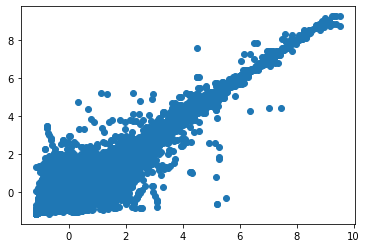

In [22]:
plt.scatter(y_test,prediction)

In [23]:
import scipy.stats
result = scipy.stats.linregress(y_test, prediction)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(y_test, prediction))
print(metrics.max_error(y_test, prediction))
print(metrics.mean_absolute_error(y_test, prediction))
print(metrics.median_absolute_error(y_test, prediction))




0.9916366258606231
0.0
0.988436603642211
0.0002089231405542083
0.9833125167192198
5.838152378997048
0.04046166286104567
0.009924244668073318


In [24]:
r, p = scipy.stats.pearsonr(y_test, prediction)
print (r)
print (p)

0.9916366258606251
0.0


In [25]:
result = scipy.stats.spearmanr(y_test, prediction)
print (result.correlation)
print (result.pvalue)

0.9821732591432395
0.0


In [26]:

result = scipy.stats.kendalltau(y_test, prediction)
print (result.correlation)
print (result.pvalue)

0.937808939817476
0.0


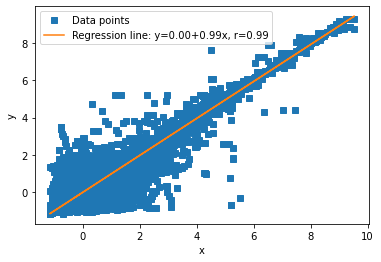

In [27]:
x=y_test
y=prediction
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()